Link to github repo: https://github.com/robertjleggat/LESA-BERT

# Introduction



It is difficult to develop effective machine learning models for text classification on small and imbalanced datasets. This issue is common in healthcare applications, as complex models like BERT often lead to overfitting when trained on small datasets.

The paper implements LESA-BERT (Label Embedding on Self-Attention in BERT). The value of this model is that it incorporates label embeddings into the self-attention mechanism of BERT to better capture label-token associations.

Link to original paper: [Students Need More Attention: BERT-based Attention Model for Small Data with Application to Automatic Patient Message Triage](https://proceedings.mlr.press/v126/si20a.html)

# Scope of Reproducibility:

1.   Hypothesis 1: Label embeddings improve the performance of the BioBERT model on small datasets

In order to test this hypothesis, I will test the data on identical datasets using both models that use and do not use custom label embeddings.

# Methodology


## Environment

I used python version 3.11 for this notebook. My dependencies included torch, pandas, transformers, matplotlib, numpy, and sklearn.

##  Data

Unfortunately, according to the Github repository it says “Unfortunately, we can't release the message-urgency data used in our paper due to privacy issues.” I have not yet been able to retrieve the medical data associated with the project. However, I have been able to retrieve alternate data that can still be used to test the methods described in the paper.

I decided to synthetically generate data for both training and testing. I stored these files in "./data.csv" and "./test_data_copy.csv"

In [2]:
'''
Define the custom Dataset class
'''

from torch.utils.data import Dataset
class MedicalNotesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long),
            'label_ids': torch.tensor(label, dtype=torch.long)  # Add this line
        }

Training Dataset


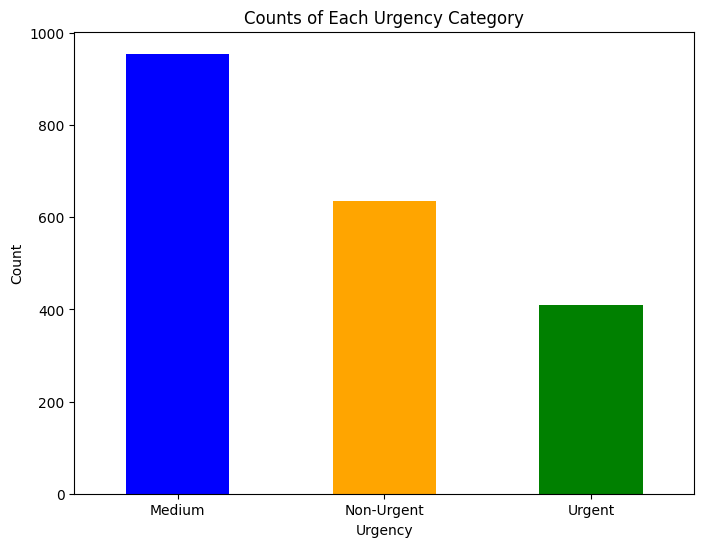

Test Dataset


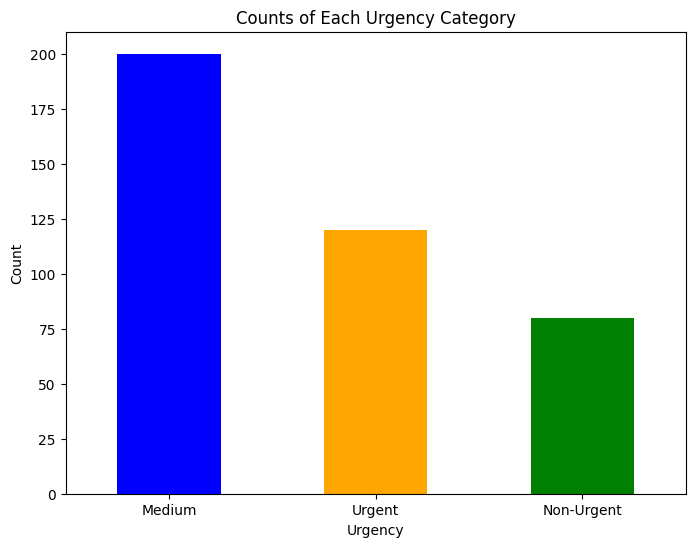

In [21]:
'''
Load the raw data into the custom Dataset class
'''

import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

RAW_DATA_DIR = './data.csv'
RAW_TEST_DATA_DIR = './test_data_copy.csv'

def load_raw_data(raw_data_dir):
    '''
    Load the raw data from raw_data_dir into a dataframe
    '''
    
    # implement this function to load raw data to dataframe/numpy array/tensor
    return pd.read_csv(raw_data_dir)

    # Assuming the CSV has columns named 'Patient Portal Message' and 'Urgency'
    texts = data['Patient Portal Message'].tolist()
    # Convert labels to categorical integer values
    label_dict = {'Non-Urgent': 0, 'Medium': 1, 'Urgent': 2}
    labels = data['Urgency'].apply(lambda x: label_dict[x]).tolist()

    
def calculate_stats(raw_data):
    '''
    Calculate statistics about the raw data
    '''
    # TODO: Implement this
    # Plot histogram of the counts of each category
    plt.figure(figsize=(8, 6))
    raw_data['Urgency'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
    plt.xlabel('Urgency')
    plt.ylabel('Count')
    plt.title('Counts of Each Urgency Category')
    plt.xticks(rotation=0)
    plt.show()


def process_data(raw_data):
    '''
    Process the raw_data dataframe
    '''
    
    texts = raw_data['Patient Portal Message'].tolist()
    
    # Convert labels to categorical integer values
    label_dict = {'Non-Urgent': 0, 'Medium': 1, 'Urgent': 2}
    labels = raw_data['Urgency'].apply(lambda x: label_dict[x]).tolist()
    
    return texts, labels


raw_data = load_raw_data(RAW_DATA_DIR)
raw_test_data = load_raw_data(RAW_TEST_DATA_DIR)

print("Training Dataset")
calculate_stats(raw_data)
print("Test Dataset")
calculate_stats(raw_test_data)

texts, labels = process_data(raw_data)
test_texts, test_labels = process_data(raw_test_data)

# Retrieve the tokenizer for the model
model_path = 'dmis-lab/biobert-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load data into the custom MedicalNotesDataset
dataset = MedicalNotesDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
test_dataset = MedicalNotesDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

##   Model

The original model is cited at the end of this notebook

The link to the original paper's repo is included at the end of the notebook as well.

I will test building the model off of both the BERT and BioBERT models. The paper provides the label embedding keywords that were used to modify each of the models, so I will be able to test the given keywords as well as experiment in this area.

Due to the long training time for each model, I saved the trained versions of each model to be easily imported.

In [4]:
"""
Define the custom model class
"""

from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn

class BertForSequenceClassificationWithLabelEmbedding(BertPreTrainedModel):
    def __init__(self, config, label_embeddings):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size + label_embeddings.shape[1], config.num_labels)
        self.label_embeddings = nn.Embedding.from_pretrained(label_embeddings, freeze=False)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None, label_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask)
        pooled_output = outputs[1]
        
        label_embeds = self.label_embeddings(label_ids)
        pooled_output = torch.cat((pooled_output, label_embeds), dim=1)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)
   

In [22]:
'''
Implement label embeddings for the BioBERT model
'''

import numpy as np
import torch

from transformers import (
    AutoTokenizer,
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
import warnings
warnings.filterwarnings('ignore')


def get_init_label_embedding(urgent_tokens, medium_tokens, tokenizer, embedding, device):
    """
    Compute embeddings for 'urgent', 'medium', and a random 'non-urgent' category using token lists.
    Args:
        urgent_tokens (list of list of str): Tokens associated with urgent messages.
        medium_tokens (list of list of str): Tokens associated with medium messages.
        tokenizer (Tokenizer): Tokenizer that converts tokens to IDs.
        embedding_layer (nn.Module): PyTorch embedding layer used to get embeddings from token IDs.
        device (torch.device): Device to perform computations on.

    Returns:
        numpy.ndarray: Array of embeddings for 'non-urgent', 'medium', and 'urgent'.
    """
    def get_embeds(tokens):
        """
        Convert a list of token lists to a single averaged embedding vector.
        """
        embeds = []
        for t in tokens:
            ids = torch.tensor(tokenizer.convert_tokens_to_ids(t), dtype=torch.long, device=device)
            embeds.append(embedding(ids).mean(0))
        return torch.stack(embeds, dim=0).mean(0).detach()

    urgent_embeds = get_embeds(urgent_tokens)
    medium_embeds = get_embeds(medium_tokens)
    non_urgent_embeds = torch.tensor(np.random.normal(size=embedding.embedding_dim), dtype=torch.float, device=device).to(device)
    return torch.stack([non_urgent_embeds, medium_embeds, urgent_embeds], axis=0)


# Tokens taken from Table 2 of the original paper
# Immediate and soon represent different magnitudes of urgency for the conditions
urgent_tokens = [['all', '##ergic'], ['it', '##chy', 'bleeding'], ['difficulty', 'breathing'], ['short', '##ness', 'of', 'breathing'], ['chest', 'pain'], ['confusion'],
                    ['di', '##sor', '##ient', '##ation'],['loss', 'of', 'con', '##cious', '##ness'], ['occurred', 'today'], ['ing', '##est', '##ion', 'of', 'poison'],['numb', '##ness'],
                    ['severe'], ['para', '##lysis'], ['pain'], ['s', '##lu', '##rred'], ['g', '##ar', '##bled'], ['new', 'onset'], ['suicide'] ]
medium_tokens = [['loss', 'of', 'balance'], ['loss', 'of', 'coordination'], ['di', '##zzi', '##ness'], ['swelling'], ['headache'], ['nausea'], ['vomit'], ['p', '##al', '##pit', '##ation'],
               ['pain'], ['blurred', 'vision'], ['double', 'vision'], ['w', '##hee', '##zing']]

# Download the BioBERT dataset
model_path = 'dmis-lab/biobert-v1.1'
tokenizer = AutoTokenizer.from_pretrained(model_path)

device='cuda'
torch.cuda.empty_cache()
config_class, model_class, tokenizer_class = (BertConfig, BertForSequenceClassification, BertTokenizer)
config = BertConfig.from_pretrained(model_path, num_labels=3, hidden_size=768)
model = model_class.from_pretrained(model_path, config=config).to('cuda')


label_embedding = get_init_label_embedding(urgent_tokens, medium_tokens, tokenizer, model.bert.embeddings.word_embeddings, device=device).to(device)
model = BertForSequenceClassificationWithLabelEmbedding(config, label_embedding).to('cuda')
w = torch.tensor(label_embedding, device=device).to(device)
model.bert.embeddings.label_embeddings = torch.nn.Embedding.from_pretrained(w, freeze=False).to(device)

## Training

The batch size was determined above when I initialized the Dataloaders. I set the batch size to 16 as I determined through experimentation that this was the largest value that my computing infrastructure could handle without running out of memory.

I set the learning rate to be 5e-5 and the hidden size to 768, as these were the default values used in the original paper

The type of hardware that I used was a NVIDIA GeForce RTX 3060 Laptop GPU. The average runtime for each epoch was 43 minutes, and I only ended up using 1 full epoch due to my computing limitations. Since this was repeated for both the experimental and control model, this resulted in 1.5 GPU hours being used.

In [23]:
'''
Train the model with label embeddings (Took 43 minutes to complete)
'''

from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, get_scheduler
import time


TRAIN_MODEL = False
SAVED_MODEL_PATH = './saved_model_with_label_embeddings'
SAVED_CONTROL_MODEL_PATH = './saved_model_no_embeddings'

# Code used for training the model (control model trained in a separate script)
if TRAIN_MODEL:
    
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_epochs = 1
    num_training_steps = num_epochs * len(dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    model.train()

    start_time = time.time()
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0.0

        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate progress percentage
            total_batches = num_epochs * len(dataloader)
            current_batch = epoch * len(dataloader) + batch_idx + 1
            progress_percentage = (current_batch / total_batches) * 100

            # Calculate estimated time remaining
            elapsed_time = time.time() - start_time
            avg_time_per_batch = elapsed_time / current_batch
            remaining_batches = total_batches - current_batch
            estimated_time_remaining = remaining_batches * avg_time_per_batch

            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], "
                  f"Loss: {loss.item():.4f}, Progress: {progress_percentage:.2f}%, "
                  f"Estimated Time Remaining: {estimated_time_remaining/60:.2f} minutes")

        epoch_loss /= len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}, "
              f"Time: {time.time() - epoch_start_time:.2f} seconds")
        
else:
    model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_PATH).to(device)
    control_model = AutoModelForSequenceClassification.from_pretrained(SAVED_CONTROL_MODEL_PATH).to(device)

In [24]:
"""
Save the model after training.
"""
# model_save_path = "./saved_model_with_label_embeddings"
# model.save_pretrained(model_save_path)

'\nSave the model after training.\n'

I have not yet had the opportunity to evaluate the model, but when I do I will track the macro F1 score, macro precision, and macro recall scores for both the baseline and the modified models. I will keep track of how these scores change over time as the model develops.

## Evaluation


In [25]:
'''
Evaluate the model's accuracy with and without label embeddings
'''

import torch
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    start_time = time.time()
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            label_ids = batch['label_ids'].to(device)  # Ensure label_ids are provided
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            
            # Calculate progress percentage
            total_batches = len(dataloader)
            current_batch = batch_idx + 1
            progress_percentage = (current_batch / total_batches) * 100

            # Calculate estimated time remaining
            elapsed_time = time.time() - start_time
            avg_time_per_batch = elapsed_time / current_batch
            remaining_batches = total_batches - current_batch
            estimated_time_remaining = remaining_batches * avg_time_per_batch
            
            print(f"Estimated Time Remaining: {estimated_time_remaining/60:.2f} minutes")

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=['Non-Urgent', 'Medium', 'Urgent'])

    print(f"Test Accuracy: {accuracy:.2f}")
    print("\nClassification Report:\n", report)

    # return accuracy, report

evaluate_model(model, test_dataloader, 'cuda')
evaluate_model(control_model, test_dataloader, 'cuda')

Estimated Time Remaining: 0.52 minutes
Estimated Time Remaining: 0.45 minutes
Estimated Time Remaining: 0.42 minutes
Estimated Time Remaining: 0.39 minutes
Estimated Time Remaining: 0.37 minutes
Estimated Time Remaining: 0.35 minutes
Estimated Time Remaining: 0.33 minutes
Estimated Time Remaining: 0.31 minutes
Estimated Time Remaining: 0.29 minutes
Estimated Time Remaining: 0.27 minutes
Estimated Time Remaining: 0.26 minutes
Estimated Time Remaining: 0.24 minutes
Estimated Time Remaining: 0.22 minutes
Estimated Time Remaining: 0.20 minutes
Estimated Time Remaining: 0.18 minutes
Estimated Time Remaining: 0.16 minutes
Estimated Time Remaining: 0.15 minutes
Estimated Time Remaining: 0.13 minutes
Estimated Time Remaining: 0.11 minutes
Estimated Time Remaining: 0.09 minutes
Estimated Time Remaining: 0.07 minutes
Estimated Time Remaining: 0.05 minutes
Estimated Time Remaining: 0.04 minutes
Estimated Time Remaining: 0.02 minutes
Estimated Time Remaining: 0.00 minutes
Test Accuracy: 0.60

Clas

# Results

The table of results is included above for both the experimental and control models. Unfortunately, it does not appear that adding the label embeddings made a difference in the predictions of the model. In this respect, unfortunately we were unable to reproduce the results of the original paper.

# Discussion

Unfortunately, I was unable to replicate the findings of the original paper with my generated dataset. I assume that the label embeddings approach would be more appropriate and useful with the complexity of the real world dataset that they used in the original paper.

It was difficult to find any real medical notes dataset due to the sensitive nature of this type of data. It would be helpful for reproduction if the authors of the original paper could publish an anonymized version of their dataset in order to be accessible to the general public.

# References

1.   Si, S., Wang, R., Wosik, J., Zhang, H., Dov, D., Wang, G. &amp; Carin, L.. (2020). Students Need More Attention: BERT-based Attention Model for Small Data with Application to Automatic Patient Message Triage. <i>Proceedings of the 5th Machine Learning for Healthcare Conference</i>, in <i>Proceedings of Machine Learning Research</i> 126:436-456 Available from https://proceedings.mlr.press/v126/si20a.html.



# Link to the original repo

https://github.com/shijing001/text_classifiers